In [ ]:
!pip install -U autogluon

In [2]:
# 필요한 라이브러리 불러오기
from autogluon.tabular import TabularPredictor

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import re

## 데이터 불러오기

In [3]:
# 학습 데이터
train = pd.read_csv('car_prices_regression_dataset/train.csv')

# 테스트 데이터
test = pd.read_csv('car_prices_regression_dataset/test.csv')

# 원본 데이터
Original = pd.read_csv('car_prices_regression_dataset/used_cars.csv')

In [4]:
train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [5]:
Original.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


## EDA
* 데이터셋 확인
* 결측치 확인
* target 및 데이터 시각화

### 데이터 확인

In [6]:
# 데이터 정보 확인
train.info()
print("\n학습 데이터 갯수: ", train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB

학습 데이터 갯수:  (188533, 13)


In [7]:
# 데이터 통계 정보 확인
train.describe()

,id,model_year,milage,price
count,188533.000000,188533.000000,188533.000000,1.885330e+05
mean,94266.000000,2015.829998,65705.295174,4.387802e+04
std,54424.933488,5.660967,49798.158076,7.881952e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,47133.000000,2013.000000,24115.000000,1.700000e+04
50%,94266.000000,2017.000000,57785.000000,3.082500e+04
75%,141399.000000,2020.000000,95400.000000,4.990000e+04
max,188532.000000,2024.000000,405000.000000,2.954083e+06


In [8]:
# 결측치 확인
train.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [9]:
test.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64

In [10]:
# 필요없는 id 컬럼 제거
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

### 데이터 시각화

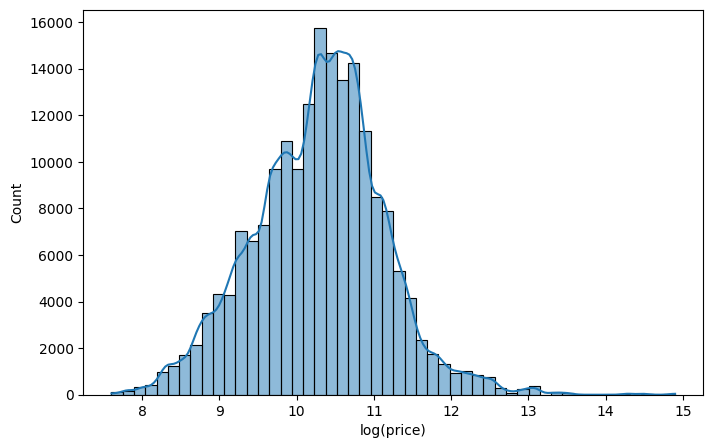

In [11]:
# 목표 변수 시각화
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(train['price']), bins=50, kde=True)
plt.xlabel('log(price)')
plt.ylabel('Count')
plt.show()

array([[<Axes: title={'center': 'model_year'}>,
        <Axes: title={'center': 'milage'}>],
       [<Axes: title={'center': 'price'}>, <Axes: >]], dtype=object)

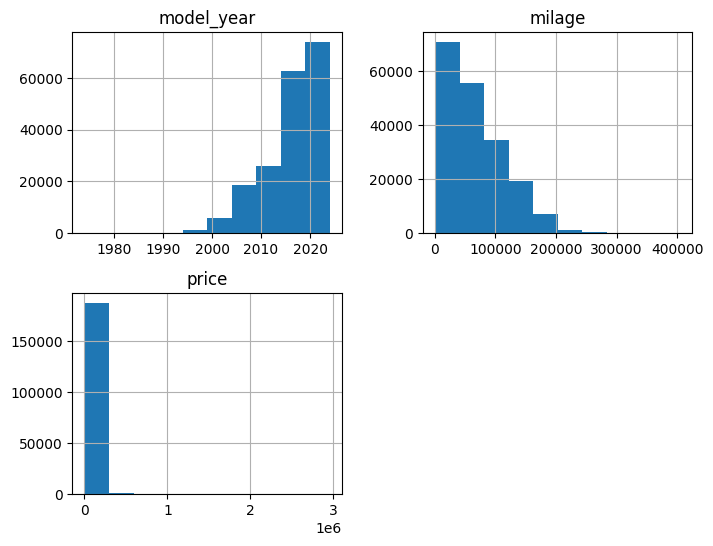

In [20]:
# 히스토그램 시각화
train.hist(figsize=(8, 6))

In [19]:
categorical_columns = train.select_dtypes(include=['object']).columns

# 
unique_values = {col: train[col].nunique() for col in categorical_columns}

for col, unique_count in unique_values.items():
    print(f"{col}: {unique_count} unique values")

brand: 57 unique values
model: 1897 unique values
fuel_type: 7 unique values
engine: 1117 unique values
transmission: 52 unique values
ext_col: 319 unique values
int_col: 156 unique values
accident: 2 unique values
clean_title: 1 unique values


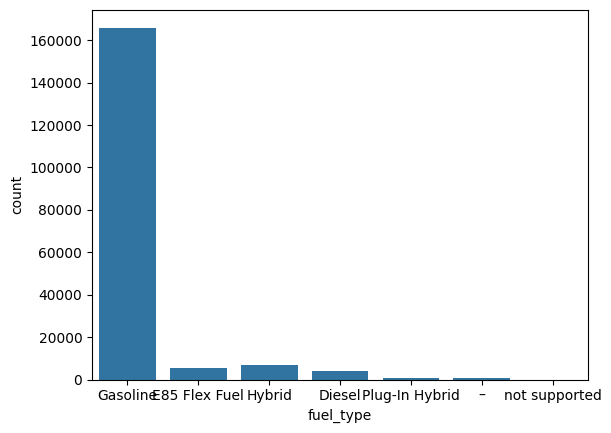

In [ ]:
# 연료 유형 시각화
sns.countplot(data=train, x=train['fuel_type'])
plt.show()

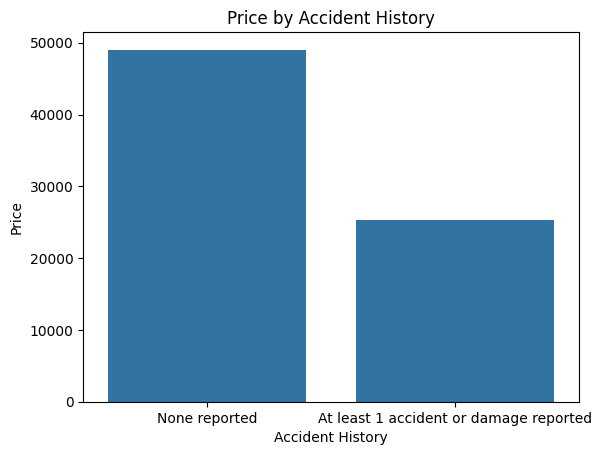

In [38]:
# 사고 이력 대비 중고차 가격 시각화
sns.barplot(x='accident', y='price', data=train, errorbar=None)
plt.xlabel('Accident History')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

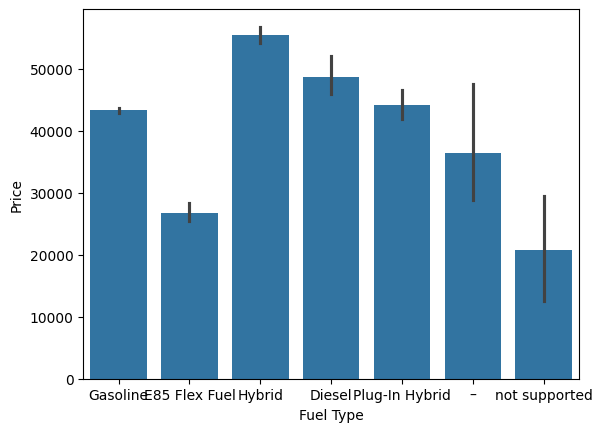

In [35]:
# 연료 종류별 중고차 가격 시각화
sns.barplot(data=train, x='fuel_type', y='price')
plt.xlabel('Fuel Type')
plt.ylabel('Price')

In [43]:
from sklearn.preprocessing import LabelEncoder

# 라벨 인코딩 수행한 학습 데이터 생성을 위해 학습 데이터 복사
train_encoded = train[train.columns].copy()

# 범주형 컬럼만 추출
object_data = train_encoded.select_dtypes(include='object').columns

# 각 범주형 변수에 대해 라벨 인코딩 수행
le = LabelEncoder()
for column in object_data:
    train_encoded[column] = le.fit_transform(train[column])


In [44]:
train_encoded

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,31,495,2007,213000,2,116,38,312,71,1,0,4200
1,28,930,2002,143250,2,366,38,263,10,0,0,4999
2,9,1575,2002,136731,1,640,38,38,71,1,0,13900
3,16,758,2017,19500,2,863,49,29,14,1,0,45000
4,36,1077,2021,7388,2,259,23,29,10,1,0,97500
...,...,...,...,...,...,...,...,...,...,...,...,...
188528,8,604,2017,49000,2,866,49,304,10,1,0,27500
188529,36,206,2018,28600,2,770,31,304,14,0,0,30000
188530,36,223,2021,13650,2,921,23,304,14,1,0,86900
188531,3,1471,2022,13895,2,512,1,82,14,1,1,84900


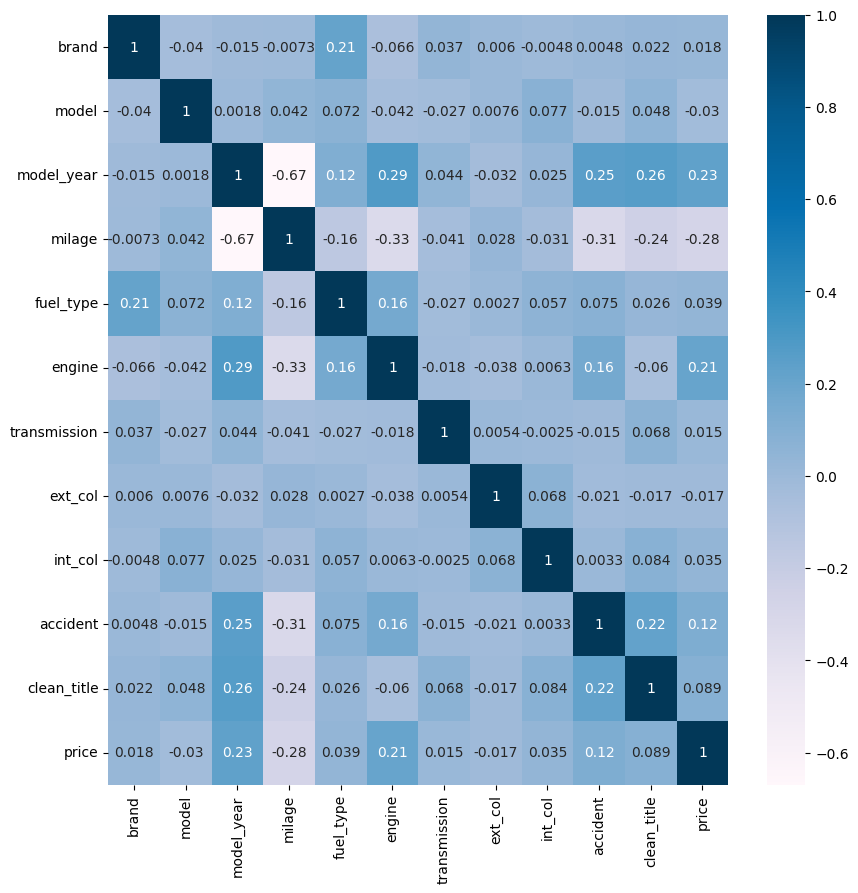

In [42]:
# 상관관계 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(train_encoded.corr(), annot=True, cbar=True, cmap='PuBu')
plt.show()
